<img src="http://drive.google.com/uc?export=view&id=1tpOCamr9aWz817atPnyXus8w5gJ3mIts" width=500px>

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#  Top-n list of restaurants on consumer preference

### INDUSTRY CASE STUDY - Popularity based + Collborative Filtering Based Recommendation system
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Case study problem statement:

### Context:

The dataset was obtained from a recommender system prototype. The task was to generate a top-n list of restaurants according to 
the consumer preferences.


### Input data details : https://archive.ics.uci.edu/ml/machine-learning-databases/00232/

(In here you will find rating_final.csv inside RCdata folder to be used)

### Expected output details: Restaurant recommendation system

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

### Steps

#### 1. Input libraries

#### 2. Data Analysis and preparation

#### 3. Popularity based Recommendation System

#### 4. Collaborative Filtering Recommendation System

#### 5. Insights

#### 6. Optional

### 1. Input libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [1]:
!pip install surprise

In [39]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

from surprise import Dataset 
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,classification_report

In [40]:
%config Completer.use_jedi = False

## 2. Data Analysis and preparation

### 2.1 Read the dataset and check info to understand the dataset

In [41]:
import os
os.chdir(r'D:\D\AI\Great learning 2021\Recommendation system\Assignment')
df = pd.read_csv("rating_final.csv")
df.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


### 2.2 Check statistical summary and write your observations

In [42]:
df.describe()

# There are only three classes of ratings high, medium and low.
# Even there are three classes for food_rating and service_rating

,placeID,rating,food_rating,service_rating
count,1161.000000,1161.000000,1161.000000,1161.000000
mean,134192.041344,1.199828,1.215332,1.090439
std,1100.916275,0.773282,0.792294,0.790844
min,132560.000000,0.000000,0.000000,0.000000
25%,132856.000000,1.000000,1.000000,0.000000
50%,135030.000000,1.000000,1.000000,1.000000
75%,135059.000000,2.000000,2.000000,2.000000
max,135109.000000,2.000000,2.000000,2.000000


### 2.3 Check if there are any missing values

In [43]:
df.isna().sum()

userID            0
placeID           0
rating            0
food_rating       0
service_rating    0
dtype: int64

### 2.4 Check minimum and maximum values for rating feature. Display its frequency distribution using appropriate graph

The minimum and maximum values are 0 and 2 



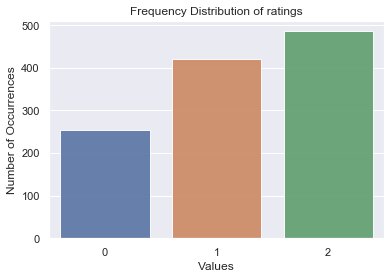

In [44]:
print("The minimum and maximum values are", df["rating"].min(), "and", df["rating"].max(), "\n")

%matplotlib inline

carrier_count = df["rating"].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of ratings')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Values', fontsize=12)
plt.show()

### 2.5 Check number of unique users and items (places) in the data

In [47]:
df["userID"].nunique()

138

In [46]:
df["placeID"].nunique()

130

### 2.6 Sort users by their number of ratings and display top 10 users who have given most number of ratings

In [48]:
df.groupby("userID").agg({"placeID":"count"})

,placeID
userID,
U1001,9
U1002,10
U1003,13
U1004,8
U1005,9
...,...
U1134,16
U1135,14
U1136,10


In [49]:
df.groupby("userID").size().sort_values(ascending=False).head(10)

userID
U1061    18
U1106    18
U1134    16
U1024    15
U1022    14
U1089    14
U1137    14
U1135    14
U1003    13
U1016    13
dtype: int64

### 2.7. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 5 or more number of ratings). Report shape of the final dataset

In [50]:
counts = df["userID"].value_counts()
counts

U1061    18
U1106    18
U1134    16
U1024    15
U1137    14
         ..
U1107     3
U1138     3
U1021     3
U1047     3
U1074     3
Name: userID, Length: 138, dtype: int64

In [51]:
counts[counts >= 5].index

Index(['U1061', 'U1106', 'U1134', 'U1024', 'U1137', 'U1135', 'U1022', 'U1089',
       'U1097', 'U1003',
       ...
       'U1064', 'U1026', 'U1119', 'U1077', 'U1043', 'U1066', 'U1102', 'U1012',
       'U1065', 'U1063'],
      dtype='object', length=115)

In [52]:
df_final = df[df["userID"].isin(counts[counts>=5].index)]
df_final.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


### 2.8 Check number of unique users and items in the dataset

In [53]:
df_final["userID"].nunique()

115

In [54]:
df_final["placeID"].nunique()

129

## 3. Popularity Recommender model. (Non-personalised)

### 3.1 Check count of user_id for each unique product and save it as score 

In [55]:
data = df_final.groupby("placeID").agg({"userID" : "count"}).reset_index()
data.head()

,placeID,userID
0,132560,4
1,132561,2
2,132564,1
3,132572,15
4,132583,4


In [56]:
data.rename(columns={"userID" : "score"}, inplace = True)

In [57]:
data.head()

,placeID,score
0,132560,4
1,132561,2
2,132564,1
3,132572,15
4,132583,4


### 3.2 Sort the products based on the score (calculated above)

In [58]:
data_sorted = data.sort_values(["score"], ascending=False).reset_index()

In [59]:
data_sorted

,index,placeID,score
0,122,135085,36
1,30,132825,32
2,79,135032,28
3,32,132834,25
4,97,135052,25
...,...,...,...
124,62,134987,2
125,17,132668,1
126,19,132715,1
127,2,132564,1


In [60]:
data_sorted = data_sorted.drop(["index"], axis = 1)
data_sorted.head()

,placeID,score
0,135085,36
1,132825,32
2,135032,28
3,132834,25
4,135052,25


### 3.3 Create a new column called 'Rank' having the ascending recommendation rank based upon score 

In [61]:
data_sorted["Rank"] = data_sorted["score"].rank(ascending=0, method="dense")

In [62]:
data_sorted.head()

,placeID,score,Rank
0,135085,36,1.0
1,132825,32,2.0
2,135032,28,3.0
3,132834,25,4.0
4,135052,25,4.0


### 3.4 Get the top 10 recommendation based on their rank

In [63]:
top_x = input("Enter no of recommendations needed")
top_x = int(top_x)

Enter no of recommendations needed5


In [64]:
recommendations = data_sorted["placeID"].head(top_x)

In [65]:
recommendations

0    135085
1    132825
2    135032
3    132834
4    135052
Name: placeID, dtype: int64

## 4. Collaborative Filtering model

### 4.1 Define rating scale and convert dataframe into surprise dataset

In [69]:
from surprise import Dataset,Reader

reader = Reader(rating_scale = (0,2))
data = Dataset.load_from_df(df_final[["userID", "placeID", "rating"]], reader)
data

### 4.2 Split the above surprise dataset into train and test set using surprise split function

In [70]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.25, random_state=1)

### 4.3 Print size of train and test set

In [74]:
userID = []
placeID = []
ratings = []

for (uid, iid, rating) in trainset.all_ratings():
    userID.append(trainset.to_raw_uid(uid))
    placeID.append(trainset.to_raw_iid(iid))
    ratings.append(rating)
dict = {"userID" : userID, "placeID" : placeID, "rating" :ratings}
training_df = pd.DataFrame(dict)
training_df

,userID,placeID,rating
0,U1069,132847,0.0
1,U1069,135082,0.0
2,U1069,135108,0.0
3,U1069,132845,0.0
4,U1069,135069,0.0
...,...,...,...
804,U1007,135058,1.0
805,U1007,135108,1.0
806,U1065,132654,1.0
807,U1065,132706,2.0


In [78]:
trainset.n_ratings

809

In [76]:
testset

[('U1062', 135085, 0.0),
 ('U1112', 135026, 1.0),
 ('U1113', 135046, 2.0),
 ('U1081', 135043, 0.0),
 ('U1064', 135052, 2.0),
 ('U1053', 132825, 1.0),
 ('U1056', 135085, 2.0),
 ('U1045', 132834, 1.0),
 ('U1088', 135082, 2.0),
 ('U1075', 135066, 2.0),
 ('U1048', 135034, 2.0),
 ('U1006', 132572, 1.0),
 ('U1033', 135045, 2.0),
 ('U1050', 132560, 0.0),
 ('U1043', 132613, 1.0),
 ('U1058', 135076, 2.0),
 ('U1019', 132834, 0.0),
 ('U1049', 135085, 0.0),
 ('U1100', 134976, 2.0),
 ('U1013', 135085, 1.0),
 ('U1066', 135019, 2.0),
 ('U1059', 132754, 2.0),
 ('U1085', 132872, 0.0),
 ('U1064', 135060, 1.0),
 ('U1049', 135042, 0.0),
 ('U1126', 135057, 2.0),
 ('U1098', 132825, 1.0),
 ('U1013', 132951, 2.0),
 ('U1112', 132572, 0.0),
 ('U1086', 135063, 1.0),
 ('U1033', 132572, 1.0),
 ('U1026', 132654, 0.0),
 ('U1022', 135081, 0.0),
 ('U1003', 132862, 1.0),
 ('U1084', 132723, 1.0),
 ('U1050', 132609, 0.0),
 ('U1108', 132723, 2.0),
 ('U1033', 132951, 2.0),
 ('U1120', 132846, 2.0),
 ('U1100', 132768, 2.0),


### 4.4 Build a default SVd model using train set

In [80]:
from surprise import SVD
svd_model = SVD(random_state=1)
svd_model.fit(trainset)

### 4.5 Make prediction for test set and convert test prediction into a dataframe

In [81]:
train_pred = svd_model.test(trainset.build_testset())
test_pred = svd_model.test(testset)

In [82]:
pred_df = pd.DataFrame(test_pred)
pred_df.head()

,uid,iid,r_ui,est,details
0,U1062,135085,0.0,0.819938,{'was_impossible': False}
1,U1112,135026,1.0,0.891964,{'was_impossible': False}
2,U1113,135046,2.0,0.888664,{'was_impossible': False}
3,U1081,135043,0.0,0.787662,{'was_impossible': False}
4,U1064,135052,2.0,1.111542,{'was_impossible': False}


In [83]:
train_pred_df = pd.DataFrame(train_pred)
train_pred_df.head()

,uid,iid,r_ui,est,details
0,U1069,132847,0.0,0.562865,{'was_impossible': False}
1,U1069,135082,0.0,0.574818,{'was_impossible': False}
2,U1069,135108,0.0,0.566819,{'was_impossible': False}
3,U1069,132845,0.0,0.620233,{'was_impossible': False}
4,U1069,135069,0.0,0.479389,{'was_impossible': False}


In [85]:
train_pred_df.head(5)

,uid,iid,r_ui,est,details
0,U1069,132847,0.0,0.562865,{'was_impossible': False}
1,U1069,135082,0.0,0.574818,{'was_impossible': False}
2,U1069,135108,0.0,0.566819,{'was_impossible': False}
3,U1069,132845,0.0,0.620233,{'was_impossible': False}
4,U1069,135069,0.0,0.479389,{'was_impossible': False}


### 4.6 Check RMSe and MAE of train and test predictions

In [86]:
print("Train RMSE: ", accuracy.rmse(train_pred))
print("Test RMSE: ", accuracy.rmse(test_pred))

RMSE: 0.4701
Train RMSE:  0.47013627654207774
RMSE: 0.6720
Test RMSE:  0.671985990727099


In [87]:
print("Train MAE: ", accuracy.mae(train_pred))
print("Test MAE: ", accuracy.mae(test_pred))

MAE:  0.3930
Train MAE:  0.3930241461673168
MAE:  0.5744
Test MAE:  0.574449128052681


### 4.7 Write a function to make top n recommendation to a user. The function should take a userID, data, and n as input arguments

In [88]:
pred_df.head()

,uid,iid,r_ui,est,details
0,U1062,135085,0.0,0.819938,{'was_impossible': False}
1,U1112,135026,1.0,0.891964,{'was_impossible': False}
2,U1113,135046,2.0,0.888664,{'was_impossible': False}
3,U1081,135043,0.0,0.787662,{'was_impossible': False}
4,U1064,135052,2.0,1.111542,{'was_impossible': False}


In [89]:
from collections import defaultdict

def get_top_n(preds, userid, n):
    
    top_n = defaultdict(list)
    
    for uid, iid, r_ui, est, details in preds:
        top_n[uid].append((iid, est))
        
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x:x[1], reverse = True)
        top_n[uid] = user_ratings[:n]
        
    return top_n[userid]
        
        

### 4.8 Check top 3 recommendations for userID:- 'U1028'

In [98]:
get_top_n(test_pred, "U1028", 3)

[(132733, 1.2203125720284387),
 (132613, 1.0673744682337087),
 (132663, 0.9067560954429552)]

## 5. Summarize your insights

In [ ]:
# It seems that for user U1028 the estimation are arounf 0.9 to 1.22 are the top ones.

## Optional
### Use GridSearch CV to get the best parameters for SVD model

In [93]:
param = {"n_factors" : list(range(20, 200))}
tuner = GridSearchCV(SVD, param, measures = ["rmse"], cv = 5)
tuner.fit(data)

In [95]:
tuner.best_params["rmse"]

{'n_factors': 33}

In [96]:
tuner.best_score["rmse"]

0.6538105713223048